In [1]:
import tidy3d as td
import tidy3d.web as web
from tidy3d import material_library, Medium, Structure, MeshOverrideStructure
from tidy3d.plugins.autograd.invdes import tanh_projection

import autograd as autograd
import autograd.numpy as anp
from typing import List, Tuple

import matplotlib.pylab as plt

## Create Simulation Structures

### Define basic simulation parameters

Most custom parameters are defined in the following block. However, the `param_to_design_info` needs to be carefully reviewed if the structure has changes in the layer numbers and dielectric/metal combinations as it is tightly bound to a specific structure.

In [2]:
Ni = material_library['Ni']['RakicLorentzDrude1998'] # Valid for 0.25 - 6.2 um
SiO2 = Medium(permittivity = 3.9, name='SiO2')

wvl0 = 2.35 # microns
freq0 = td.constants.C_0 / wvl0
bandwidth = 0.25 # microns
wvl_range = [1.35, 3.35] # microns
wvl_points = 101
wvls = anp.linspace(wvl_range[0], wvl_range[1], wvl_points)
freqs = td.constants.C_0 / wvls

fwidth = td.constants.C_0 / (wvl0 * 20)
run_time =  50 / fwidth
shutoff = 1e-05

monitor_freqs = [td.constants.C_0 / wvl0]

buffer_size = wvl0 # distance between the source/monitor and the computational domain
distance = wvl0 # distance between the source/monitor and the structure

# Define the structure constraints
# Default substrate values
sub_metal_thickness = 0.2
sub_dielectric_thickness = 0.25
num_of_sub_layers = 2
# Substrate constraints
sub_metal_min_thickness = 0.1
sub_metal_max_thickness = 0.3
sub_dielectric_min_thickness = 0.15
sub_dielectric_max_thickness = 0.35
sub_thickness_constraints_min = [sub_metal_min_thickness, sub_dielectric_min_thickness]
sub_thickness_constraints_max = [sub_metal_max_thickness, sub_dielectric_max_thickness]

# Default cuboid values
cuboid_metal_thickneness = 0.025
cuboid_dielectric_thickness = 0.1
num_of_cuboid_layers = 2 * 5 # 5 bilayers
# Cuboid constraints
cuboid_min_length = 1.0
cuboid_max_length = 3.4
cuboid_min_width = 1.0
cuboid_max_width = 3.4
cuboid_metal_min_thickness = 0.015
cuboid_metal_max_thickness = 0.035
cuboid_dielectric_min_thickness = 0.05
cuboid_dielectric_max_thickness = 0.2
cuboid_thickness_constraints_min = [cuboid_metal_min_thickness, cuboid_dielectric_min_thickness, cuboid_metal_min_thickness, cuboid_dielectric_min_thickness, cuboid_metal_min_thickness, cuboid_dielectric_min_thickness, cuboid_metal_min_thickness, cuboid_dielectric_min_thickness, cuboid_metal_min_thickness, cuboid_dielectric_min_thickness]
cuboid_thickness_constraints_max = [cuboid_metal_max_thickness, cuboid_dielectric_max_thickness, cuboid_metal_max_thickness, cuboid_dielectric_max_thickness, cuboid_metal_max_thickness, cuboid_dielectric_max_thickness, cuboid_metal_max_thickness, cuboid_dielectric_max_thickness, cuboid_metal_max_thickness, cuboid_dielectric_max_thickness]

sub_materials = [Ni, SiO2]
cuboid_materials = [Ni, SiO2, Ni, SiO2, Ni, SiO2, Ni, SiO2, Ni, SiO2]

# Simulation domain
Lx = 3.5
Ly = 3.5
Lz = 3 * buffer_size + distance + \
     sub_metal_max_thickness + sub_dielectric_max_thickness + \
     5 * (cuboid_metal_max_thickness + cuboid_dielectric_max_thickness)
min_steps_per_wvl = 24
dl_sub = 0.1
dl_cuboid = 0.015

### Define source and monitor objects

In [3]:
SOURCE_PLANEWV_NAME = 'source_planewave'
FLUX_MONITOR_NAME = 'monitor_flux'
FIELD_MONITOR_NAME = 'monitor_field'

source_planewave = td.PlaneWave(
    center=(0, 0, Lz/2 - 2*buffer_size),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    size=(td.inf, td.inf, 0),
    direction='-',
    pol_angle=0,
    name=SOURCE_PLANEWV_NAME,
)

monitor_flux = td.FluxMonitor(
    center=(0, 0, Lz/2 - buffer_size),
    size=(td.inf, td.inf, 0),
    freqs=monitor_freqs,
    name=FLUX_MONITOR_NAME,
)

monitor_field = td.FieldMonitor(
    center=(0, 0, Lz/2 - buffer_size),
    size=(td.inf, td.inf, 0),
    freqs=monitor_freqs,
    name=FIELD_MONITOR_NAME,
    colocate=False,
)

### Function to create the structure

Parameter frame structure: 

| substrate thicknesses from bottom up | cuboid thicknesses from bottom up | cuboid length | cuboid width |
| --- | --- | --- | --- |


In [4]:
def make_dynamic_structures(design_info: anp.array) -> List[Structure]:
    if design_info is None: return []

    sub_thicknesses = design_info[:num_of_sub_layers]
    cuboid_thicknesses = design_info[num_of_sub_layers:num_of_sub_layers + num_of_cuboid_layers]
    cuboid_length = design_info[-2]
    cuboid_width = design_info[-1]

    # Substrate
    substrate = []
    z_center = -Lz/2 + buffer_size
    for i in range(num_of_sub_layers):
        z_center += sub_thicknesses[i] / 2 + (sub_thicknesses[i-1] / 2 if i > 0 else 0)
        
        substrate.append(
            td.Structure(
                geometry=td.Box(
                    center=(0, 0, z_center),
                    size=(td.inf, td.inf, sub_thicknesses[i]),
                ),
                medium=sub_materials[i],
            )
        )

    z_center += sub_thicknesses[-1] / 2

    # Cuboid
    cuboid = []
    for i in range(num_of_cuboid_layers):
        z_center += cuboid_thicknesses[i] / 2 + (cuboid_thicknesses[i-1] / 2 if i > 0 else 0)
        
        cuboid.append(
            td.Structure(
                geometry=td.Box(
                    center=(0, 0, z_center),
                    size=(cuboid_length, cuboid_width, cuboid_thicknesses[i]),
                ),
                medium=cuboid_materials[i],
            )
        )

    return substrate + cuboid

def get_override_structure_v1(design_info: anp.array) -> List[MeshOverrideStructure]:
    sub_thicknesses = design_info[:num_of_sub_layers]
    cuboid_thicknesses = design_info[num_of_sub_layers:num_of_sub_layers + num_of_cuboid_layers]
    cuboid_length = design_info[-2]
    cuboid_width = design_info[-1]

    sub_thickness = sum(sub_thicknesses)
    cuboid_thickness = sum(cuboid_thicknesses)

    override_structure_sub = td.MeshOverrideStructure(
        geometry=td.Box(
            center=(0, 0, -Lz/2 + buffer_size + sub_thickness/2),
            size=(td.inf, td.inf, sub_thickness),
        ),
        dl=[dl_sub, dl_sub, dl_sub],
    )

    override_structure_cuboid = td.MeshOverrideStructure(
        geometry=td.Box(
            center=(0, 0, -Lz/2 + buffer_size + sub_thickness + cuboid_thickness/2),
            size=(cuboid_length, cuboid_width, cuboid_thickness),
        ),
        dl=[dl_cuboid, dl_cuboid, dl_cuboid],
    )

    return [override_structure_sub, override_structure_cuboid]

from autograd.tracer import getval

def get_override_structure(design_info: anp.array) -> List[MeshOverrideStructure]:
    sub_thicknesses = design_info[:num_of_sub_layers]
    cuboid_thicknesses = design_info[num_of_sub_layers:num_of_sub_layers + num_of_cuboid_layers]
    cuboid_length = design_info[-2]
    cuboid_width = design_info[-1]

    sub_thickness = sum(sub_thicknesses)
    cuboid_thickness = sum(cuboid_thicknesses)

    override_structure_sub = td.MeshOverrideStructure(
        geometry=td.Box(
            center=(0, 0, getval(-Lz/2 + buffer_size + sub_thickness/2)),
            size=(td.inf, td.inf, getval(sub_thickness)),
        ),
        dl=[dl_sub, dl_sub, dl_sub],
    )

    override_structure_cuboid = td.MeshOverrideStructure(
        geometry=td.Box(
            center=(0, 0, getval(-Lz/2 + buffer_size + sub_thickness + cuboid_thickness/2)),
            size=(getval(cuboid_length), getval(cuboid_width), getval(cuboid_thickness)),
        ).to_static(),
        dl=[dl_cuboid, dl_cuboid, dl_cuboid],
    )
   
    return [override_structure_sub, override_structure_cuboid]

### Function to create the simulation object

In [5]:
def make_sim(design_info: anp.array) -> td.Simulation:
    boundary_spec = td.BoundarySpec(
        x=td.Boundary(minus=td.Periodic(), plus=td.Periodic()),
        y=td.Boundary(minus=td.Periodic(), plus=td.Periodic()),
        z=td.Boundary(minus=td.PML(), plus=td.PML()),
    )

    override_structures = get_override_structure(design_info)

    grid_spec = td.GridSpec.auto(
        wavelength=wvl0,
        min_steps_per_wvl=min_steps_per_wvl,
        override_structures=override_structures,
    )

    dynamic_structures = make_dynamic_structures(design_info)

    sim = td.Simulation(
        center=(0, 0, 0),
        size=(Lx, Ly, Lz),
        run_time=run_time,
        boundary_spec=boundary_spec,
        grid_spec=grid_spec,
        structures=dynamic_structures,
        sources=[source_planewave],
        monitors=[monitor_field],
        shutoff=shutoff,
    )

    return sim

### Check point

In [6]:
anp.random.seed(2)

random_sub_thicknesses = anp.random.uniform(sub_metal_min_thickness, sub_metal_max_thickness, num_of_sub_layers)
random_cuboid_length = anp.random.uniform(cuboid_min_length, cuboid_max_length)
random_cuboid_width = anp.random.uniform(cuboid_min_width, cuboid_max_width)
random_cuboid_thicknesses = anp.random.uniform(cuboid_metal_min_thickness, cuboid_metal_max_thickness, num_of_cuboid_layers)
random_design_info = anp.concatenate([random_sub_thicknesses, random_cuboid_thicknesses, [random_cuboid_length, random_cuboid_width]])

random_sim = make_sim(random_design_info)

print(f"random_sub_thicknesses: {random_sub_thicknesses}")
print(f"random_cuboid_length: {random_cuboid_length}")
print(f"random_cuboid_width: {random_cuboid_width}")
print(f"random_cuboid_thicknesses: {random_cuboid_thicknesses}")

random_sim.plot_3d()
plt.show()

job_random_sim = td.web.Job(simulation=random_sim, task_name='week08_design_credit_estimation', verbose=True)
estimated_cost = td.web.estimate_cost(job_random_sim.task_id)
print(f"Estimated cost: {estimated_cost}")

random_sub_thicknesses: [0.18719898 0.10518525]
random_cuboid_length: 2.319189946908902
random_cuboid_width: 2.0447737422838648
random_cuboid_thicknesses: [0.02340736 0.0216067  0.01909297 0.02738542 0.02099309 0.02033655
 0.02742268 0.02558284 0.0176916  0.02527156]


18:46:30 BST Created task 'week08_design_credit_estimation' with task_id        
             'fdve-28019aa4-047d-43be-9dbd-9156badaf353' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=332857;https://tidy3d.simulation.cloud/workbench?taskId=fdve-28019aa4-047d-43be-9dbd-9156badaf353\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=876267;https://tidy3d.simulation.cloud/workbench?taskId=fdve-28019aa4-047d-43be-9dbd-9156badaf353\taskId]8;;\]8;id=332857;https://tidy3d.simulation.cloud/workbench?taskId=fdve-28019aa4-047d-43be-9dbd-9156badaf353\=]8;;\]8;id=40242;https://tidy3d.simulation.cloud/workbench?taskId=fdve-28019aa4-047d-43be-9dbd-9156badaf353\fdve]8;;\]8;id=332857;https://tidy3d.simulation.cloud/workbench?taskId=fdve-28019aa4-047d-43be-9dbd-9156badaf353\-28019aa4-047]8;;\
             ]8;id=332857;https://tidy3d.simulation.cloud/workbench?taskId=fdve-28019aa4-047d-43be-9dbd-9156badaf353\d-43be-9dbd-9156badaf353']8;;\.

Output()

18:46:38 BST Maximum FlexCredit cost: 0.516. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

Estimated cost: 0.516325355657954


## Objective Function

### Define the target

wvl_min:  2.23, wvl_max:  2.48


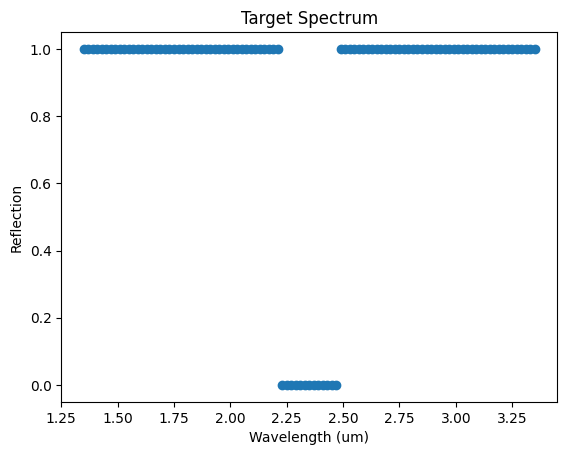

In [7]:
def target() -> anp.array:
    wvl_min = wvl0 - bandwidth / 2.0
    wvl_max = wvl0 + bandwidth / 2.0
    target = anp.where(anp.logical_and(wvls >= wvl_min, wvls <= wvl_max), 0.0, 1.0)
    print(f"wvl_min: {wvl_min: .2f}, wvl_max: {wvl_max: .2f}")
    return target

plt.scatter(wvls, target())
plt.xlabel('Wavelength (um)')
plt.ylabel('Reflection')
plt.title('Target Spectrum')
plt.show()

In [8]:
def evaluate_flux_error_MAE(flux: anp.array) -> float:
    error = anp.sum(anp.abs(flux - target())) / wvl_points
    return error

def evaluate_flux_error_MSE(flux: anp.array) -> float:
    error = anp.sum((flux - target())**2) / wvl_points
    return error

### Convert param to design information

Projector equation: 

$$
\text{value} = v_{min} + (v_{max} - v_{min}) * \frac{\tanh(\beta \eta) + \tanh(\beta (x-\eta))}{\tanh(\beta \eta) + \tanh(\beta (1-\eta))}
$$

In [9]:
def projector(x: anp.array, vmin: float, vmax: float, beta: float=1.0, eta: float=0.5) -> anp.array:
    value = vmin + (vmax - vmin) * (anp.tanh(beta*eta) + anp.tanh(beta*(x-eta))) / (anp.tanh(beta*eta) + anp.tanh(beta*(1-eta)))
    return value

In [10]:
def params_to_design_info_custom(params: anp.array) -> anp.array:
    if params is None: return None

    # Extract the parameters
    param_sub_thicknesses = params[:num_of_sub_layers]
    param_cuboid_thicknesses = params[num_of_sub_layers:num_of_sub_layers + num_of_cuboid_layers]
    param_cuboid_length = params[-2]
    param_cuboid_width = params[-1]

    # Scale the parameters
    # Substrate thicknesses
    sub_thicknesses = anp.zeros(num_of_sub_layers)
    for i in range(num_of_sub_layers):
        sub_thicknesses[i] = projector(param_sub_thicknesses[i], sub_thickness_constraints_min[i], sub_thickness_constraints_max[i])
        print(f"sub_thicknesses[{i}]: {sub_thicknesses[i]}")
    

    # Cuboid thicknesses
    cuboid_thicknesses = anp.zeros(num_of_cuboid_layers)
    for i in range(num_of_cuboid_layers):
        cuboid_thicknesses[i] = projector(param_cuboid_thicknesses[i], cuboid_thickness_constraints_min[i], cuboid_thickness_constraints_max[i])
        print(f"cuboid_thicknesses[{i}]: {cuboid_thicknesses[i]}")

    # Cuboid length
    cuboid_length = projector(param_cuboid_length, cuboid_min_length, cuboid_max_length)

    # Cuboid width
    cuboid_width = projector(param_cuboid_width, cuboid_min_width, cuboid_max_width)

    return anp.concatenate([sub_thicknesses, cuboid_thicknesses, [cuboid_length, cuboid_width]])

def params_to_design_info(params: anp.array) -> anp.array:
    if params is None: return None
    # return params

    # Extract the parameters
    param_sub_thicknesses = params[:num_of_sub_layers]
    param_cuboid_thicknesses = params[num_of_sub_layers:num_of_sub_layers + num_of_cuboid_layers]
    param_cuboid_length = params[-2]
    param_cuboid_width = params[-1]

    # Set the constraints (temporary)
    sub_min = 0.1
    sub_max = 0.35
    cub_min = 0.015
    cub_max = 0.2

    # Scale the parameters
    # Substrate thicknesses
    substrate_thicknesses = tanh_projection(param_sub_thicknesses)
    substrate_thicknesses = substrate_thicknesses * (sub_max - sub_min) + sub_min
    # Cuboid thicknesses
    cuboid_thicknesses = tanh_projection(param_cuboid_thicknesses)
    cuboid_thicknesses = cuboid_thicknesses * (cub_max - cub_min) + cub_min
    # Cuboid length
    cuboid_length = tanh_projection(param_cuboid_length)
    cuboid_length = cuboid_length * (cuboid_max_length - cuboid_min_length) + cuboid_min_length
    # Cuboid width
    cuboid_width = tanh_projection(param_cuboid_width)
    cuboid_width = cuboid_width * (cuboid_max_width - cuboid_min_width) + cuboid_min_width

    return anp.concatenate([substrate_thicknesses, cuboid_thicknesses, [cuboid_length, cuboid_width]])

### Define the objective function

In [11]:
def get_flux_from_sim_data(sim_data: td.SimulationData) -> float:
    field_data = sim_data[FIELD_MONITOR_NAME]
    field_ex = field_data.

SyntaxError: invalid syntax (793070596.py, line 3)

In [ ]:
import os

sim_data_history = []

def generate_unique_task(base_path) -> Tuple[str, str]:
    i = 0
    while True:
        new_path = f"data/{base_path}_{i}.hdf5"
        new_name = f"task_{base_path}_{i}"
        if not os.path.exists(new_path):
            return new_name, new_path
        i += 1

def objective_fn(params: anp.array) -> float: 
    structure_info = params_to_design_info(params)
    sim = make_sim(structure_info)
    task_name, data_path = generate_unique_task("week08_design")
    sim_data = web.run(sim, task_name = task_name, verbose = True, path = data_path)
    sim_data_history.append(sim_data)
    flux = get_flux_from_sim_data(sim_data)
    error = evaluate_flux_error_MAE(flux)
    return error

## Optimization

### Calculate the initial state

In [ ]:
PARAMS0 = 0.01 * anp.ones((num_of_sub_layers + num_of_cuboid_layers + 2))

sim_initial = make_sim(params_to_design_info(PARAMS0))
sim_initial.plot_3d()
plt.show()

optimizer -> numbers (parameters) -> f(parameters) = design_info

In [ ]:
val_and_grad_fn = autograd.value_and_grad(objective_fn)
val_initial, grad_initial = val_and_grad_fn(PARAMS0)
print(f"Initial design\tFlux error: {val_initial}\tGradient: {grad_initial}")

### Visualize the initial state

In [ ]:
def plot_flux(itr: int): 
    flux = sim_data_history[-1][FIELD_MONITOR_NAME].flux
    plt.figure(figsize = (4, 2))
    plt.plot(td.constants.C_0 / monitor_freqs, flux)
    plt.xlabel('Wavelength (um)')
    plt.ylabel('Flux')
    plt.title(f'Flux at iteration {itr}')
    plt.show()